# Karting Performance Modeling – Final Project Notebook

<!-- 📦 1. Import Libraries -->


##  1. Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

##  2. Load and Inspect Dataset

In [6]:
df = pd.read_csv("Karting_Performance_Dataset.csv")
# print(df.head())
# print(df.info())
# print(df.describe())

##  3. Clean Data

In [10]:
df = df.dropna()

##  4. Prepare Features and Target

In [13]:
X = df.drop("LapTimeSeconds", axis=1)
y = df["LapTimeSeconds"]

##  5. Visualize Relationships

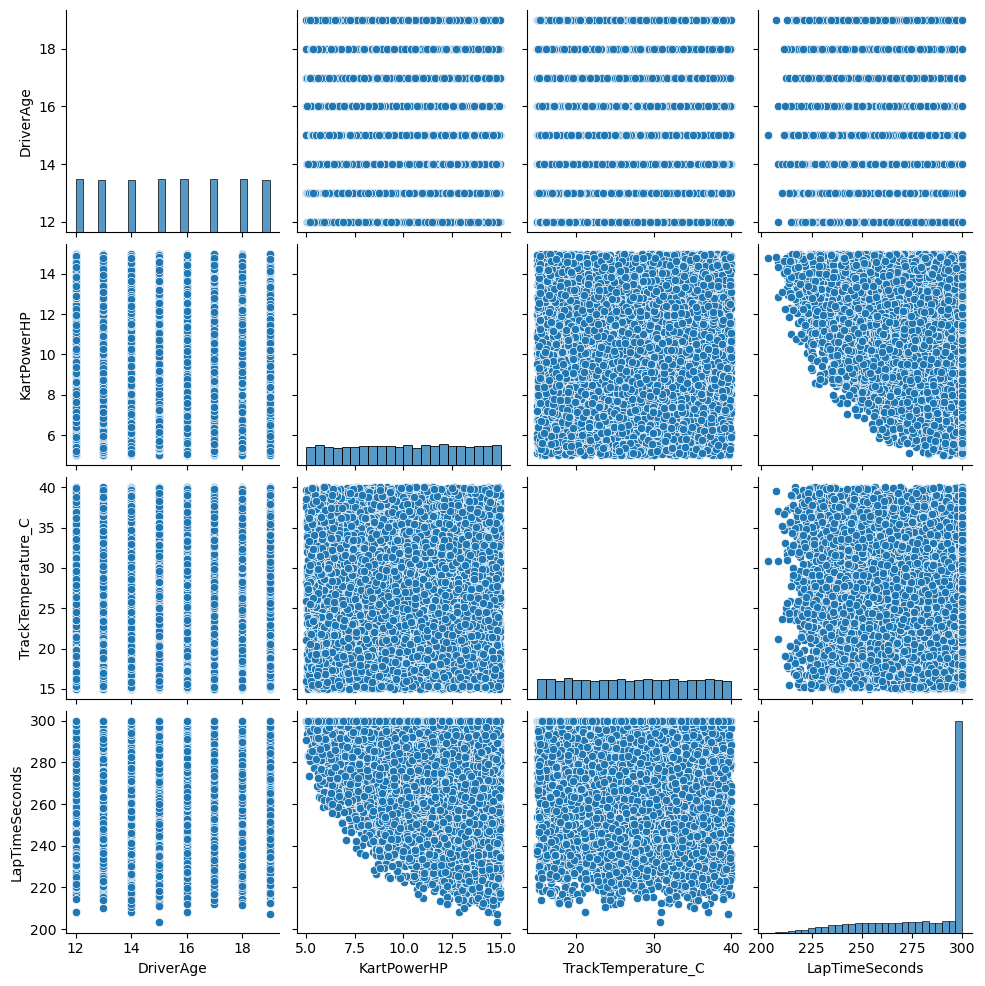

In [16]:
sns.pairplot(df[["DriverAge", "KartPowerHP", "TrackTemperature_C", "LapTimeSeconds"]])
plt.show()

##  6. Correlation Heatmap

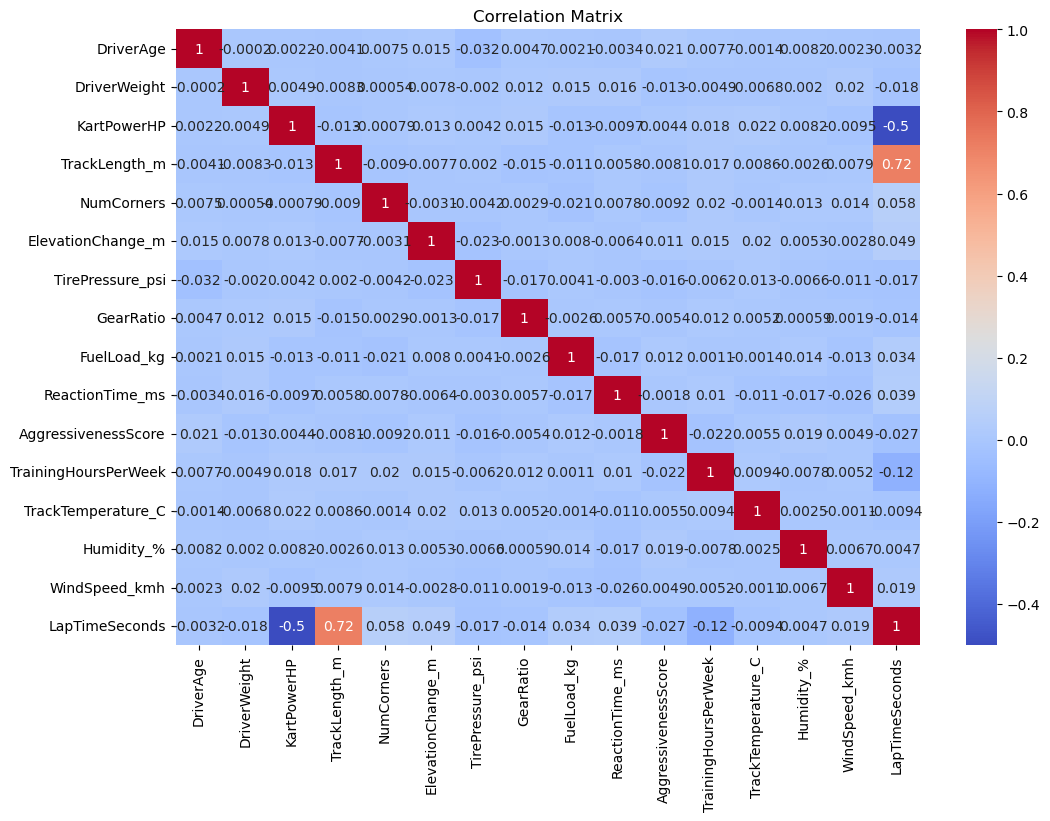

In [19]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

##  7. Train/Val/Test Split

In [22]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42)

##  8. Cross-Validation Function

In [34]:
def evaluate_model_cv(model, X_data, y_data):
    pipeline = make_pipeline(StandardScaler(), model)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    r2_scores = cross_val_score(pipeline, X_data, y_data, cv=kf, scoring='r2')
    rmse_scores = np.sqrt(-cross_val_score(pipeline, X_data, y_data, cv=kf, scoring='neg_mean_squared_error'))
    return r2_scores, rmse_scores

##  9. Base Models

In [37]:
models = {
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=9),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Support Vector Regressor": SVR(),
}
results = []

## 10. Helper Function – Prediction Plot

In [40]:
def plot_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual Lap Time")
    plt.ylabel("Predicted Lap Time")
    plt.title(f"{model_name} Predictions")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## 11. Evaluate Each Base Model


Evaluating K-Nearest Neighbors


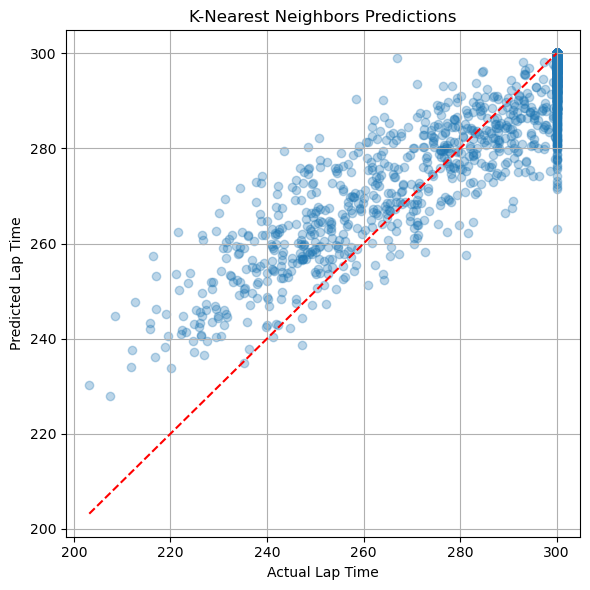


Evaluating Decision Tree


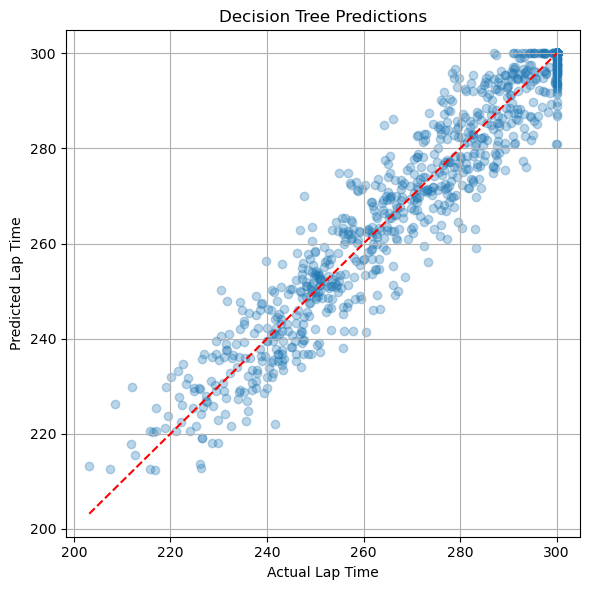


Evaluating Support Vector Regressor


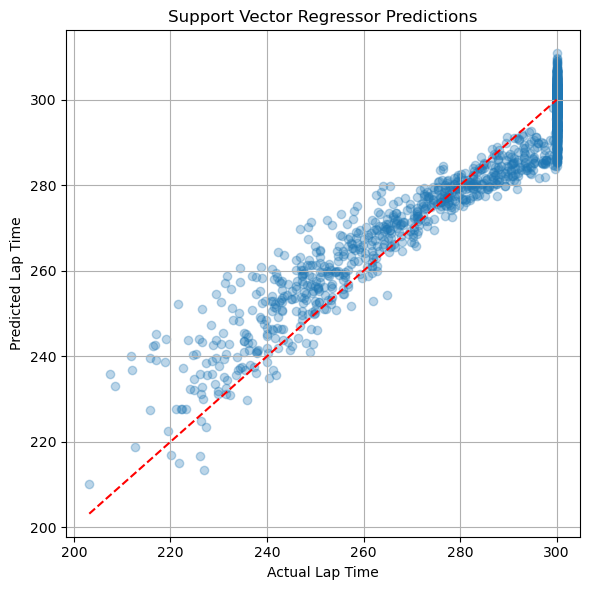

In [43]:
for name, model in models.items():
    print(f"\nEvaluating {name}")
    r2_scores, rmse_scores = evaluate_model_cv(model, X_train_val, y_train_val)
    model_pipeline = make_pipeline(StandardScaler(), model)

    model_pipeline.fit(X_train, y_train)
    y_val_pred = model_pipeline.predict(X_val)
    model_pipeline.fit(X_train_val, y_train_val)
    y_pred = model_pipeline.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append((name, np.mean(r2_scores), np.mean(rmse_scores), test_r2, test_rmse))
    plot_predictions(y_test, y_pred, name)


## 12. Hyperparameter Tuning – SVR

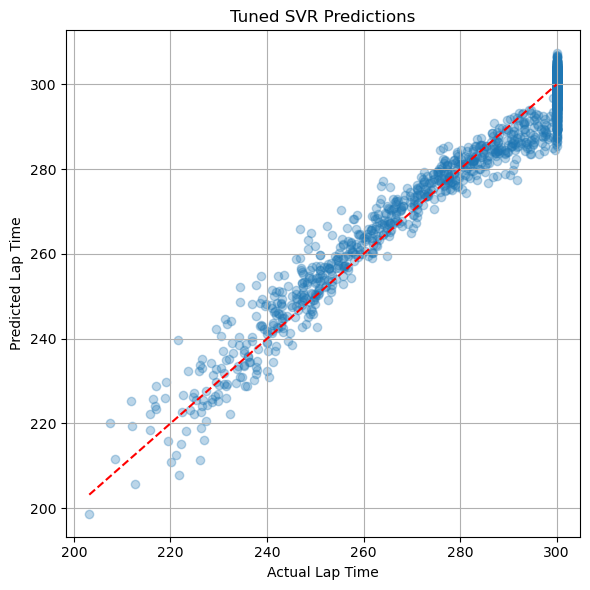

In [46]:
svr_pipeline = make_pipeline(StandardScaler(), SVR())
svr_params = {
    'svr__C': [0.1, 1, 10],
    'svr__gamma': ['scale', 0.1, 1],
    'svr__epsilon': [0.1, 0.5, 1]
}
svr_grid = GridSearchCV(svr_pipeline, svr_params, cv=5, scoring='r2', n_jobs=-1)
svr_grid.fit(X_train_val, y_train_val)
y_pred_svr = svr_grid.predict(X_test)
results.append(("Tuned SVR", svr_grid.best_score_, None, r2_score(y_test, y_pred_svr), np.sqrt(mean_squared_error(y_test, y_pred_svr))))
plot_predictions(y_test, y_pred_svr, "Tuned SVR")

## 13. Hyperparameter Tuning – Decision Tree

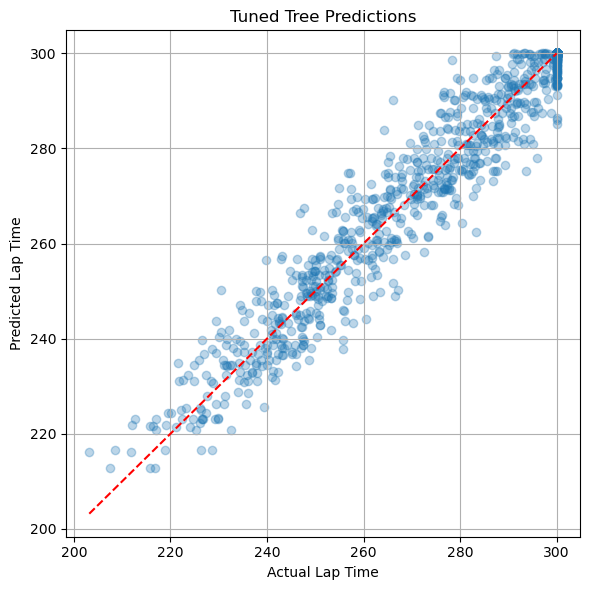

In [49]:
tree_pipeline = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=42))
tree_params = {
    'decisiontreeregressor__max_depth': [5, 10, 20],
    'decisiontreeregressor__min_samples_split': [2, 10, 50]
}
tree_grid = GridSearchCV(tree_pipeline, tree_params, cv=5, scoring='r2', n_jobs=-1)
tree_grid.fit(X_train_val, y_train_val)
y_pred_tree = tree_grid.predict(X_test)
results.append(("Tuned Tree", tree_grid.best_score_, None, r2_score(y_test, y_pred_tree), np.sqrt(mean_squared_error(y_test, y_pred_tree))))
plot_predictions(y_test, y_pred_tree, "Tuned Tree")


## 15. Leaderboard – Compare All Models

In [55]:
leaderboard = pd.DataFrame(results, columns=["Model", "CV R2", "CV RMSE", "Test R2", "Test RMSE"])
print("\n\n🏆 Final Model Leaderboard:")
print(leaderboard.sort_values(by="Test R2", ascending=False))



🏆 Final Model Leaderboard:
                      Model     CV R2    CV RMSE   Test R2  Test RMSE
3                 Tuned SVR  0.953216        NaN  0.956573   4.896136
4                Tuned Tree  0.953724        NaN  0.956267   4.913342
1             Decision Tree  0.947230   5.563152  0.949528   5.278327
2  Support Vector Regressor  0.894088   7.884165  0.902896   7.321359
0       K-Nearest Neighbors  0.783394  11.273667  0.776807  11.099762


## 16. Feature Importance – From Tuned Decision Tree

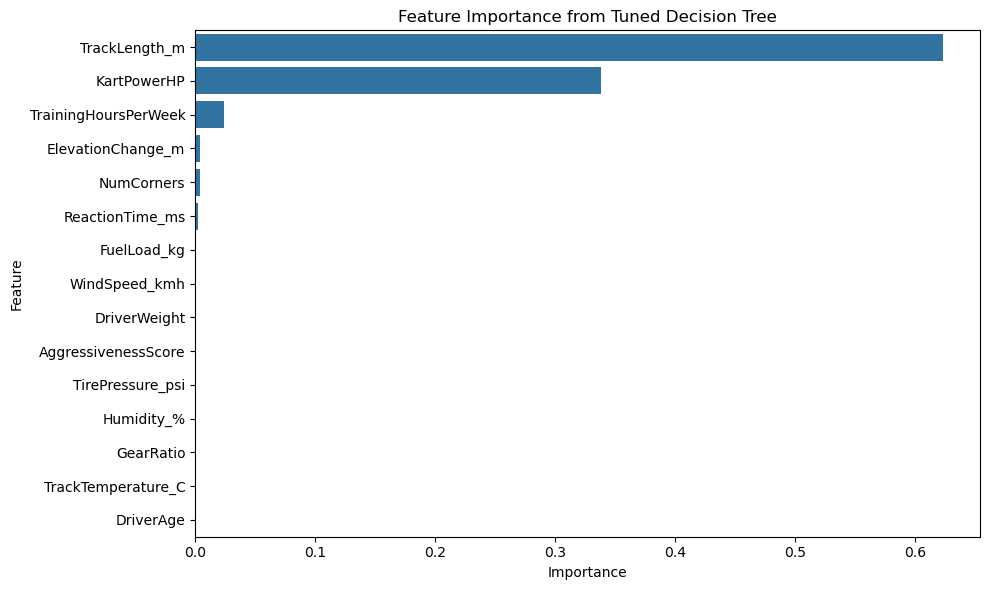

In [58]:
best_tree = tree_grid.best_estimator_.named_steps['decisiontreeregressor']
importances = best_tree.feature_importances_
features = X.columns
feat_df = pd.DataFrame({"Feature": features, "Importance": importances}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feat_df)
plt.title("Feature Importance from Tuned Decision Tree")
plt.tight_layout()
plt.show()